In [1]:
!git clone https://github.com/BenedictusKent/GarbageClassification.git

Cloning into 'GarbageClassification'...
remote: Enumerating objects: 14831, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 14831 (delta 26), reused 258 (delta 18), pack-reused 14565
Receiving objects: 100% (14831/14831), 8.17 GiB | 43.65 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Checking out files: 100% (1707/1707), done.


In [ ]:
# if model need to be saved only
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [5]:
def create_dataset(dir, label, train, test):
    temp = []
    count = 0
    for pics in os.listdir(dir):
        img = Image.open(os.path.join(dir, pics))
        img = img.resize((224,224))
        temp.append([img, label])       # using int: sparse categorical
        count += 1
    length = int(count * 0.1)
    train += temp[length:]
    test += temp[:length]
    print(str(folder) + "\t:\t" + str(count))

In [6]:
TEST = []
TEST.clear()
TRAINVAL = []
TRAINVAL.clear()

path = "/content/GarbageClassification/img/own"
for folder in os.listdir(path):
    count = 0
    dir = os.path.join(path, folder)
    if "trash" in folder:
        create_dataset(dir, 4, TRAINVAL, TEST)
    elif "glass" in folder:
        create_dataset(dir, 0, TRAINVAL, TEST)
    elif "metal" in folder:
        create_dataset(dir, 1, TRAINVAL, TEST)
    elif "paper" in folder:
        create_dataset(dir, 2, TRAINVAL, TEST)
    elif "plastic" in folder:
        create_dataset(dir, 3, TRAINVAL, TEST)

print("\nTRAINVAL:", len(TRAINVAL))
print("TEST:", len(TEST))

paper	:	670
trash	:	318
metal	:	274
glass	:	139
plastic	:	303
plastic 0

TRAINVAL: 1536
TEST: 168


In [7]:
added = []
added.clear()
for i in range(len(TRAINVAL)):
    img = TRAINVAL[i][0]
    # counter-clockwise rotation
    counter = img.rotate(random.randint(30,70))
    counter = np.asarray(counter)
    added.append([counter, TRAINVAL[i][1]])
    # clockwise rotation
    clockwise = img.rotate(-1 * random.randint(30,70))
    clockwise = np.asarray(clockwise)
    added.append([clockwise, TRAINVAL[i][1]])
    # brighter
    img = np.asarray(img)
    bright = tf.image.adjust_brightness(img, 0.2)
    bright = np.asarray(bright)
    added.append([bright, TRAINVAL[i][1]])
    # darker
    dark = tf.image.adjust_brightness(img, -0.2)
    dark = np.asarray(dark)
    added.append([dark, TRAINVAL[i][1]])
    # hue
    add = tf.image.adjust_hue(img, (random.randint(2,5)/10))
    add = np.asarray(add)
    added.append([add, TRAINVAL[i][1]])

added = np.asarray(added)

for i in range(len(TRAINVAL)):
    temp = TRAINVAL[i][0]
    temp = np.asarray(temp)
    TRAINVAL[i][0] = temp

for i in range(len(TEST)):
    temp = TEST[i][0]
    temp = np.asarray(temp)
    TEST[i][0] = temp

TRAINVAL = np.asarray(TRAINVAL)
TEST = np.asarray(TEST)

# add augmented data to training data and shuffle
print(TRAINVAL.shape, added.shape)
TRAINVAL = np.concatenate((TRAINVAL, added))
added = np.zeros(2)
print(TRAINVAL.shape)
np.random.shuffle(TRAINVAL)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(1536, 2) (7680, 2)
(9216, 2)


In [8]:
# separate train and val
length = int(len(TRAINVAL) * 0.1)
train = TRAINVAL[length:]
val = TRAINVAL[:length]

# separate feature and label
TRAINVAL = []   # clear array
xtrain = []
ytrain = []
for feature, label in train:
    xtrain.append(feature)
    ytrain.append(label)
xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)

xval = []
yval = []
for feature, label in val:
    xval.append(feature)
    yval.append(label)
xval = np.asarray(xval)
yval = np.asarray(yval)

xtest = []
ytest = []
for feature, label in TEST:
    xtest.append(feature)
    ytest.append(label)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

TEST = []       # clear array

print(xtrain.shape, ytrain.shape)
print(xval.shape, yval.shape)
print(xtest.shape, ytest.shape)

(8295, 224, 224, 3) (8295,)
(921, 224, 224, 3) (921,)
(168, 224, 224, 3) (168,)


In [9]:
resnet = tf.keras.applications.ResNet50(    # change model here if needed
    include_top = False, 
    weights = 'imagenet',
    input_shape = (224,224,3)
)

model = tf.keras.models.Sequential()
model.add(resnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy']
)

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 25,691,013
Trainable params: 25,637,893
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/30
260/260 [==============================] - 123s 330ms/step - loss: 0.7569 - accuracy: 0.7325 - val_loss: 0.3660 - val_accuracy: 0.8708
Epoch 2/30
260/260 [==============================] - 85s 325ms/step - loss: 0.2277 - accuracy: 0.9402 - val_loss: 0.1659 - val_accuracy: 0.9598
Epoch 3/30
260/260 [==============================] - 85s 326ms/step - loss: 0.0844 - accuracy: 0.9840 - val_loss: 0.1100 - val_accuracy: 0.9674
Epoch 4/30
260/260 [==============================] - 85s 325ms/step - loss: 0.0363 - accuracy: 0.9959 - val_loss: 0.0846 - val_accuracy: 0.9729
Epoch 5/30
260/260 [==============================] - 85s 325ms/step - loss: 0.0193 - accuracy: 0.9982 - val_loss: 0.0834 - val_accuracy: 0.9707
Epoch 6/30
260/260 [==============================] - 85s 325ms/step - loss: 0.0120 - accuracy: 0.9987 - val_loss: 0.0826 - val_accuracy: 0.9707
Epoch 7/30
260/260 [==============================] - 85s 325ms/step - loss: 0.0092 - accuracy: 0.9984 - val_loss: 0.0837 - val_a

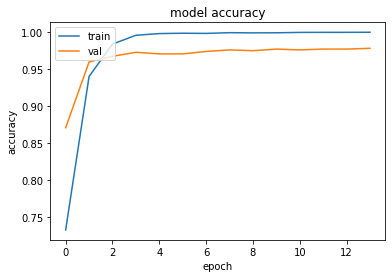

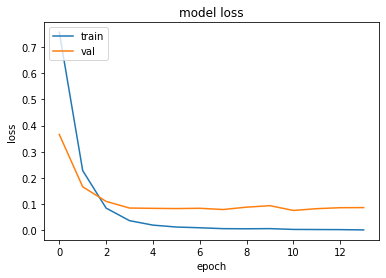

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=3)

history = model.fit(xtrain, ytrain, 
                    batch_size=32, 
                    epochs=30,
                    callbacks=callback, 
                    validation_data=(xval,yval))

# save model
# path = F"/content/gdrive/MyDrive/model/resnet.h5"
# model.save(path)

# accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
prediction = model.predict(xtest)

correct = 0
wrong_index = []
predicted_index = []

for i in range(len(prediction)):
    temp = np.argmax(prediction[i])
    if (temp == ytest[i]):
        correct += 1
    else:
        wrong_index.append(i)
        predicted_index.append(temp)

print("accuracy: ", correct / len(xtest) * 100)
print(wrong_index)
print(predicted_index)

accuracy:  94.04761904761905
[11, 16, 71, 78, 93, 135, 140, 141, 156, 164]
[3, 1, 3, 1, 2, 3, 4, 0, 0, 2]


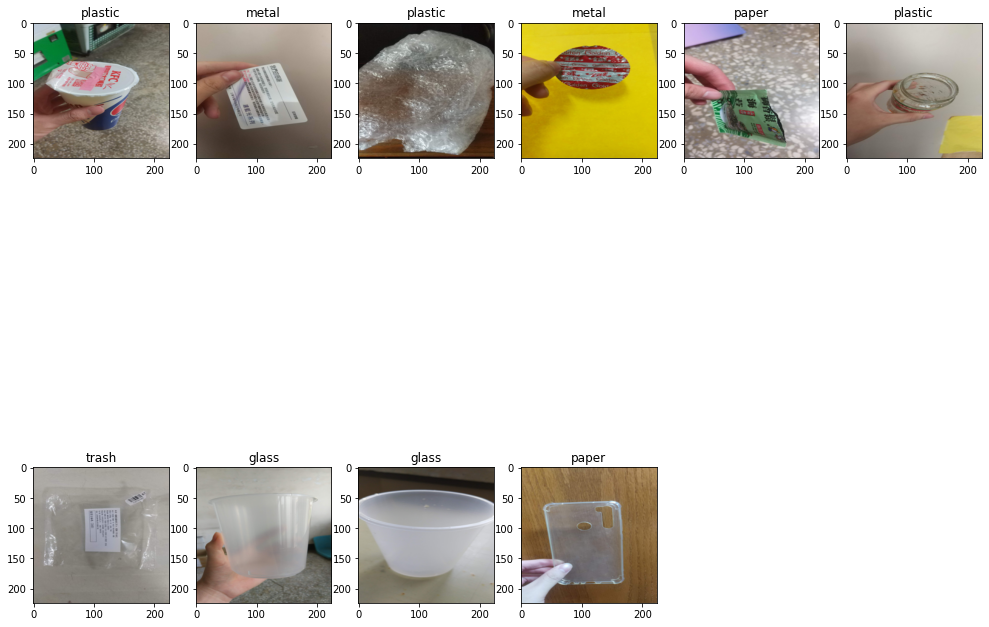

In [12]:
cols = 6
rows = int(len(wrong_index) / cols) + 1
axes = []
figs = plt.figure(figsize=(17,15))

labels = ["glass", "metal", "paper", "plastic", "trash"]

for i in range(rows * cols):
    if(i < len(wrong_index)):
        axes.append(figs.add_subplot(rows, cols, i+1))
        pic = xtest[wrong_index[i]]
        name = labels[predicted_index[i]]
        axes[-1].set_title(name)
        plt.imshow(pic)
plt.show()